# BlazePalm

In [21]:
import os
import glob
import math

import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from nets import blaze_palm 
from utils.anchors_generator import AnchorsGenerator
from utils.loss_function import SSDLoss
from utils.anchor_config import AnchorsConfig

## Reproduce Blaze Palm Model Structure

In [22]:
model = blaze_palm.build_blaze_palm_model()

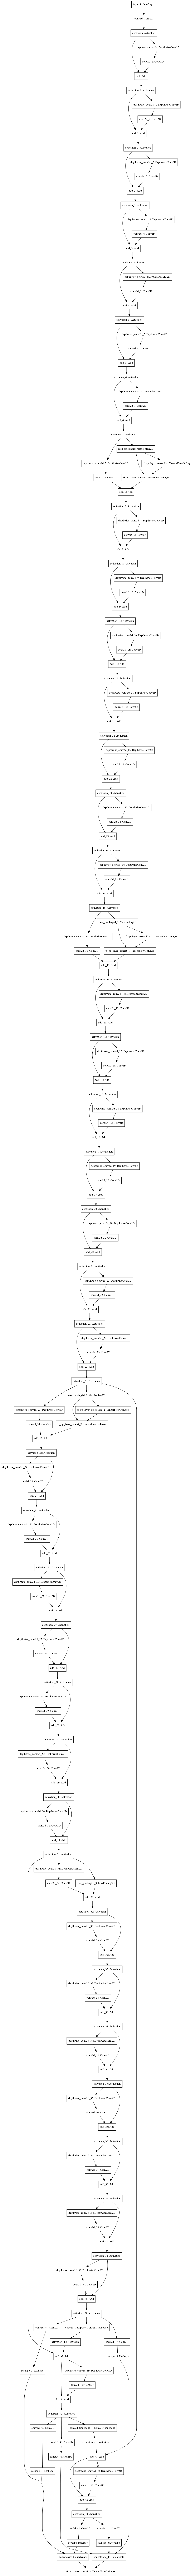

In [23]:
tf.keras.utils.plot_model(model, 
                          to_file='nets/balze_palm_model.png', 
                          show_shapes=False, 
                          show_layer_names=True, 
                          rankdir='TB', 
                          expand_nested=False,
                          dpi=96)

### Check If Model Layers Are Identical to That Release by Mideapipe

In [24]:
TFLITE_MODEL_PATH = 'original_models/palm_detection.tflite'
release_model = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)

In [25]:
layer_name_list = []
layer_shape_list = []
for layer in model.layers:
    if "conv2d" in layer.name:
        layer_name_list.append(layer.name + '/kernel')
        layer_name_list.append(layer.name + '/bias')
        layer_name_list.append(layer.name)
        layer_shape_list.append(layer.output_shape)
        layer_shape_list.append(layer.output_shape)
        layer_shape_list.append(layer.output_shape)
    else:
        layer_name_list.append(layer.name)
        layer_shape_list.append(layer.output_shape)
for i, layer in enumerate(release_model.get_tensor_details()):
    print(layer["name"].ljust(30), str(layer["shape"].tolist()).ljust(20), layer_name_list[i].ljust(30), layer_shape_list[i])

input                          [1, 256, 256, 3]     input_1                        [(None, 256, 256, 3)]
conv2d/Kernel                  [32, 3, 3, 3]        conv2d/kernel                  (None, 128, 128, 32)
conv2d/Bias                    [32]                 conv2d/bias                    (None, 128, 128, 32)
conv2d                         [1, 128, 128, 32]    conv2d                         (None, 128, 128, 32)
activation                     [1, 128, 128, 32]    activation                     (None, 128, 128, 32)
depthwise_conv2d/Kernel        [1, 3, 3, 32]        depthwise_conv2d/kernel        (None, 128, 128, 32)
depthwise_conv2d/Bias          [32]                 depthwise_conv2d/bias          (None, 128, 128, 32)
depthwise_conv2d               [1, 128, 128, 32]    depthwise_conv2d               (None, 128, 128, 32)
conv2d_1/Kernel                [32, 1, 1, 32]       conv2d_1/kernel                (None, 128, 128, 32)
conv2d_1/Bias                  [32]                 conv2d_1/bi

In [26]:
model.layers[-1].output_shape

[(None, None, 19)]

### Test Prediction

In [27]:
x = np.float32(np.random.random((8, 256, 256, 3)))
prediction = model(x)
print("model ouputs:\nshape of output1(classification): %s\nshape of output2(regression): %s" % (prediction[:,:,0].shape, prediction[:,:,1:].shape))

model ouputs:
shape of output1(classification): (8, 2944)
shape of output2(regression): (8, 2944, 18)


## Generate Anchors

**Anchor Setting**
- num_layers: 5
- min_scale: 0.1171875
- max_scale: 0.75
- input_size_height: 256
- input_size_width: 256
- anchor_offset_x: 0.5
- anchor_offset_y: 0.5
- strides: (8, 16, 32, 32, 32)
- aspect_ratios: 1.0
- fixed_anchor_size: true

In [28]:
release_anchors_path = os.path.join("original_models", "anchors.csv")
release_anchors = pd.read_csv(release_anchors_path, names=[0,1,2,3])

In [29]:
anchor_config = AnchorsConfig()
anchor_config.fixed_anchor_size = True
anchor_generator = AnchorsGenerator(anchor_config)
anchors = anchor_generator.generate()
anchors = pd.DataFrame([[anchor.x_center,anchor.y_center, int(anchor.w), int(anchor.h)] for anchor in anchors])

### Generate Anchors and Check If It Is Identical to the Mediapipe Release One

In [30]:
release_anchors.equals(anchors)

True

In [31]:
release_anchors.head(5)

,0,1,2,3
0,0.015625,0.015625,1,1
1,0.015625,0.015625,1,1
2,0.046875,0.015625,1,1
3,0.046875,0.015625,1,1
4,0.078125,0.015625,1,1


In [32]:
anchors.head(5)

,0,1,2,3
0,0.015625,0.015625,1,1
1,0.015625,0.015625,1,1
2,0.046875,0.015625,1,1
3,0.046875,0.015625,1,1
4,0.078125,0.015625,1,1


### Visualize Anchors

In [33]:
anchor_config = AnchorsConfig(aspect_ratios=[1, 0.5, 2], fixed_anchor_size=False)
anchor_generator = AnchorsGenerator(anchor_config)
anchors = anchor_generator.generate()

anchors = np.array([[anchor.x_center,anchor.y_center, anchor.w, anchor.h] for anchor in anchors])*256
anchors = anchors.astype("int")
# pd.DataFrame(anchors)

In [34]:
input_image = np.ones((1,256,256,3))*255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


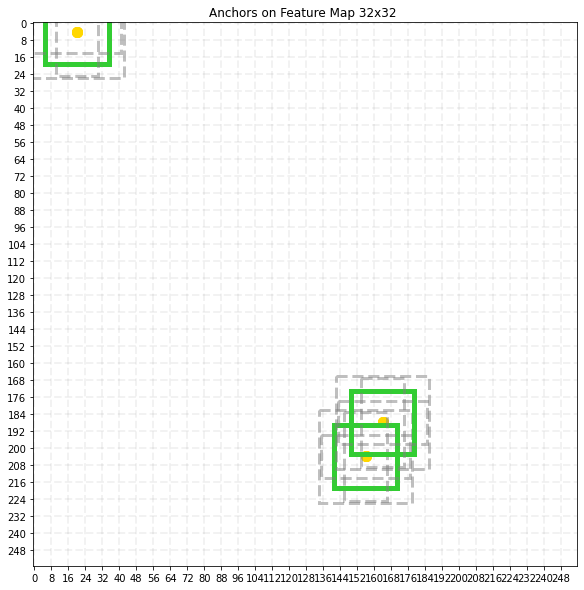

In [35]:
x = 0
padding = 0
color = ['limegreen', 'gray', 'gray', 'gray']
width = [5, 3, 3, 3]
style = ['-', '--', '--', '--']
alpha = [1, 0.5, 0.5, 0.5]
feature_map = {0:8, 4:16, 8:32, 12:32, 16:32}
c1, c2, c3, c4 = pd.DataFrame(anchors)[2].unique()[x:x+4]
condition = (
(pd.DataFrame(anchors)[2] == c1) | \
(pd.DataFrame(anchors)[2] == c2) | \
(pd.DataFrame(anchors)[2] == c3) | \
(pd.DataFrame(anchors)[2] == c4) |\
(pd.DataFrame(anchors)[3] == c1) | \
(pd.DataFrame(anchors)[3] == c2) | \
(pd.DataFrame(anchors)[3] == c3) | \
(pd.DataFrame(anchors)[3] == c4))
show_anchors = np.array(pd.DataFrame(anchors)[condition])


plt.figure(figsize=(10, 10))
plt.title("Anchors on Feature Map %sx%s "% (256//feature_map[x], 256//feature_map[x]))
result_image = np.pad(input_image.copy()[0], ((padding, padding), (padding, padding), (0, 0)), mode='constant')
for show in range(3):
    random_int = np.random.randint(len(show_anchors)//4)*4
    for i, bbox in enumerate(show_anchors[random_int:random_int+4]):
        cx, cy, w, h = bbox
        cx += padding
        cy += padding
        x1, y1, x2, y2 = (cx-w//2, cy-h//2, cx+w//2, cy+h//2)
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                 linewidth=width[i], 
                                 edgecolor=color[i],
                                 linestyle=style[i],
                                 alpha=alpha[i],
                                 facecolor="none")
        plt.gca().add_patch(rect)
        plt.scatter(cx, cy, color='gold', s=100)

rect = patches.Rectangle((padding, padding), 
                         result_image.shape[1], 
                         result_image.shape[0],
                         linewidth=0,
                         edgecolor=color[i], 
                         linestyle=style[i], 
                         facecolor="none")
plt.gca().add_patch(rect)
plt.xticks(np.arange(padding, 257+padding, feature_map[x]))
plt.yticks(np.arange(padding, 257+padding, feature_map[x]))
plt.grid(linestyle='--', linewidth=2, c='grey', alpha=0.1)
plt.imshow(result_image)
plt.show()

## Match and Encode Ground Truth Boxes and Anchors

### The Jaccard Index ( Intersection Over Union )

For bounding boxes `boxA` and `boxB` with area `areaA` and `areaB`, if their `IOU > 0.5` then positive, if thier `IOU < 0.3` then negative

$IOU = \frac{areaA \cap areaB}{areaA \cup areaB} = \frac{areaA \cap areaB}{areaA + areaB - areaA \cap areaB}$


Anchors for BlazePalm

In [36]:
anchor_config = AnchorsConfig(fixed_anchor_size=False)
anchor_generator = AnchorsGenerator(anchor_config)
anchors = anchor_generator.generate()
anchors_normalized = np.array([[anchor.x_center,anchor.y_center, anchor.w, anchor.h] for anchor in anchors])

Create a Fake Data for one image

In [37]:
ground_truth_box = np.array([129.64256-60.13495/2, 153.4913-60.13495/2, 129.64256+60.13495/2, 153.4913+60.13495/2, 136.83605957, 177.14094543, 118.33981323, 127.28881073, 130.82832336, 126.52574158, 142.27386475, 131.28793335, 152.84526062, 137.67770386, 119.28163147, 173.47927856, 105.67642212, 152.75184631]).reshape(1, -1)
ground_truth_boxes = np.concatenate([ground_truth_box, ground_truth_box-64])

In [38]:
def area(boxes):
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def intersection(boxes1, boxes2):
    [y_min1, x_min1, y_max1, x_max1] = np.split(boxes1, 4, axis=1)
    [y_min2, x_min2, y_max2, x_max2] = np.split(boxes2, 4, axis=1)
    all_pairs_min_ymax = np.minimum(y_max1, np.transpose(y_max2))
    all_pairs_max_ymin = np.maximum(y_min1, np.transpose(y_min2))
    intersect_heights = np.maximum(np.zeros(all_pairs_max_ymin.shape), all_pairs_min_ymax - all_pairs_max_ymin)
    all_pairs_min_xmax = np.minimum(x_max1, np.transpose(x_max2))
    all_pairs_max_xmin = np.maximum(x_min1, np.transpose(x_min2))
    intersect_widths = np.maximum(np.zeros(all_pairs_max_xmin.shape), all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths


def iou(boxes1, boxes2):
    """
    boxes1 and boxes2 should be in the same scale and corner format
    """
    intersect = intersection(boxes1, boxes2)
    area1 = area(boxes1)
    area2 = area(boxes2)
    union = np.expand_dims(area1, axis=1) + np.expand_dims(area2, axis=0) - intersect
    return intersect / union

def center_to_corner(center_boxes):
    """
    (cx, cy, w, h) to (y1, x1, y2, x2)
    """
    corner_boxes = np.zeros(center_boxes.shape)
    corner_boxes[:,:2] = center_boxes[:,:2] - center_boxes[:,2:] / 2
    corner_boxes[:,2:] = corner_boxes[:,:2] + center_boxes[:,2:]
    return corner_boxes

def corner_to_center(corner_boxes):
    """
    (x1, y1, x2, y2) to (cx, cy, w, h)
    """
    center_boxes = np.zeros(corner_boxes.shape)
    center_boxes[:,:2] = (corner_boxes[:,:2] + corner_boxes[:,2:]) / 2
    center_boxes[:,2:] = corner_boxes[:,2:] - corner_boxes[:,:2]
    return center_boxes

def match(annotation, anchors, match_threshold=0.5):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        match_threshold: (float) The overlap threshold used when mathing boxes. default=0.5
        annotation: (list) Ground truth labels and ground truth boxes, Shape: [(num_obj, 1), (num_obj, num_coordinate)].
        anchors: (np.array) Anchor boxes Shape: [n_priors,4].
        loc_truth: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_truth: (tensor) Tensor to be filled w/ matched indices for conf preds.
        batch_id: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    ious = iou(annotation[1][:, :4], center_to_corner(anchors))
    best_prior_overlap, best_prior_idx = np.max(ious, 1), np.argmax(ious, 1)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = np.max(ious, 0), np.argmax(ious, 0)
    best_truth_idx.squeeze()
    best_truth_overlap.squeeze()
    best_prior_idx.squeeze()
    best_prior_overlap.squeeze()
    best_truth_overlap[best_prior_idx] = 2
    for j in range(len(best_prior_idx)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = annotation[1][best_truth_idx]
    
    # Shape: [num_priors]    
    conf = annotation[0][best_truth_idx]         
    # label as background
    conf[best_truth_overlap < match_threshold] = 0  
    loc = encode(matches, anchors)
    
    # [num_priors,4] encoded offsets to learn
    # loc_truth[batch_id] = encoded_loc
    # [num_priors] top class label for each prior
    # conf_truth[batch_id] = conf
    return conf, loc

def encode(matches, anchors):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matches: (tensor) Coords of ground truth for each prior in point-form Shape: [num_priors, 18].
        anchors: (tensor) Prior boxes in center-offset form Shape: [num_priors, 18].
    Return:
        encoded location (tensor), Shape: [num_priors, 18]
    """

    # dist b/t match center and prior's center
    # (x_min, y_min, x_max, y_max) to (center)
    g_cxcy = corner_to_center(matches[:, :4])[:,:2] - anchors[:, :2]   
    g_wh = (matches[:, 2:4] - matches[:, :2])
    g_kp = matches[:, 4:].reshape(-1, 7, 2) - anchors[:, :2].reshape(-1, 1, 2)    

    return np.concatenate([g_cxcy, g_wh, g_kp.reshape(-1, 14)], 1)  # [num_priors, 18]

In [39]:
num_anchors = 2944
num_coordinates = 18
num_key_points = 7
num_classes = 1
positive_threshold = 0.5
negative_threshold = 0.5

In [40]:
ground_truth_labels = np.array([[1], [1]])
annotation = [ground_truth_labels, ground_truth_boxes/256]

In [41]:
conf, loc = match(annotation, anchors_normalized, match_threshold=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


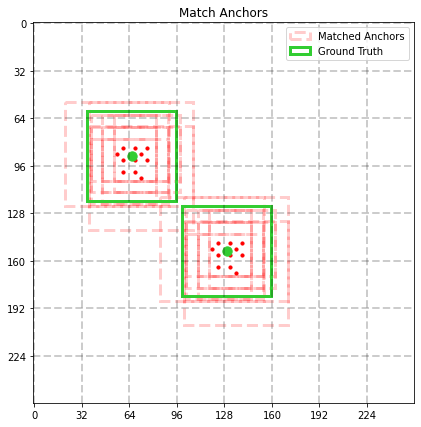

In [42]:
color = ['limegreen', 'r']
width = [3, 3]
style = ['-', '--']
alpha = [1, 0.2]


plt.figure(figsize=(7, 7))
plt.title("Match Anchors")
result_image = input_image.copy()[0]
for i, bbox in enumerate(anchors_normalized[np.where(conf != 0)[0]]*256):
    cx, cy, w, h = bbox
    x1, y1, x2, y2 = (cx-w//2, cy-h//2, cx+w//2, cy+h//2)    
    if i == 0:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[1], ec=color[1], ls=style[1], alpha=alpha[1], facecolor="none", label='Matched Anchors')
    else:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[1], ec=color[1], ls=style[1], alpha=alpha[1], facecolor="none")
    plt.gca().add_patch(rect)
    plt.scatter(cx, cy, color=color[1], s=10)

for i in range(len(annotation[1])):
    x1, y1, x2, y2 = annotation[1][:,:4][i]*256
    if i == 0:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[0], ec=color[0], ls=style[0], alpha=alpha[0], facecolor="none", label='Ground Truth')
    else:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[0], ec=color[0], ls=style[0], alpha=alpha[0], facecolor="none")
    plt.gca().add_patch(rect)
    plt.scatter((x2+x1)/2, (y2+y1)/2, color=color[0], s=87)

plt.xticks(np.arange(0, 257, 32))
plt.yticks(np.arange(0, 257, 32))
plt.grid(linestyle='--', linewidth=2, c='k', alpha=0.2)
plt.legend()
plt.imshow(result_image)
plt.show()

## Loss Function and Hard Negative Mining

**Loss Function**

There are 2 parts in loss, classification loss and localication loss

$L_{total} = L_{cls} + \alpha L_{loc}$: $\alpha=1$ by default

$L_{cls}$: could be softmax, focal loss or etc.

$L_{loc}$: smooth L1 loss, compute with only positive samples

**Hard Negative Mining**

Positive samples is relatively much less than negatives samples.

In order to handle the data embalanced problem, choose only negative samples with lowest confidence score.

The ratio `positive samples:negative samples=1:3` is recommended

Set `y_true` and `y_pred`

In [43]:
x = np.float32(np.random.random((10, 256, 256, 3)))
y_pred = model(x)

In [44]:
y_true_batch = np.zeros((10, num_anchors, num_classes+num_coordinates))
for i in range(10):
    conf, loc = match(annotation, anchors_normalized, match_threshold=0.5)
    y_true_batch[i] = np.concatenate([conf, loc * 256], axis=-1)

In [45]:
def binary_focal_loss_fixed(y_true, y_pred):
    """
    :param y_true: A tensor of the same shape as `y_pred`
    :param y_pred:  A tensor resulting from a sigmoid
    :return: Output tensor.
    """
    gamma=2.
    alpha=.25
    y_true = tf.cast(y_true, tf.float32)
    # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
    epsilon = tf.keras.backend.epsilon()
    # Add the epsilon to prediction value
    # y_pred = y_pred + epsilon
    # Clip the prediciton value
    y_pred = tf.keras.backend.clip(y_pred, epsilon, 1.0 - epsilon)
    # Calculate p_t
    p_t = tf.where(tf.keras.backend.equal(y_true, 1), y_pred, 1 - y_pred)
    # Calculate alpha_t
    alpha_factor = tf.keras.backend.ones_like(y_true) * alpha
    alpha_t = tf.where(tf.keras.backend.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
    # Calculate cross entropy
    cross_entropy = -tf.math.log(p_t)
    weight = alpha_t * tf.math.pow((1 - p_t), gamma)
    # Calculate focal loss
    loss = weight * cross_entropy
    # Sum the losses in mini_batch
#     loss = tf.keras.backend.mean(tf.keras.backend.sum(loss, axis=1))
    return loss

def smooth_L1_loss(y_true, y_pred):
    '''
    Compute smooth L1 loss, see references.
    Arguments:
        y_true (nD tensor): A TensorFlow tensor of any shape containing the ground truth data.
            In this context, the expected tensor has shape `(batch_size, #boxes, 4)` and
            contains the ground truth bounding box coordinates, where the last dimension
            contains `(xmin, xmax, ymin, ymax)`.
        y_pred (nD tensor): A TensorFlow tensor of identical structure to `y_true` containing
            the predicted data, in this context the predicted bounding box coordinates.
    Returns:
        The smooth L1 loss, a nD-1 Tensorflow tensor. In this context a 2D tensor
        of shape (batch, n_boxes_total).
    References:
        https://arxiv.org/abs/1504.08083
    '''
    absolute_loss = tf.abs(y_true - y_pred)
    square_loss = 0.5 * (y_true - y_pred)**2
    l1_loss = tf.where(tf.less(absolute_loss, 1.0), square_loss, absolute_loss - 0.5)
    return tf.reduce_sum(l1_loss, axis=-1)

In [46]:
class SSDLoss:
    '''
    The SSD loss, see https://arxiv.org/abs/1512.02325.
    '''

    def __init__(self,
                 neg_pos_ratio=3,
                 n_neg_min=0,
                 alpha=1.0):
        
        self.neg_pos_ratio = neg_pos_ratio
        self.n_neg_min = n_neg_min
        self.alpha = alpha

    def compute_loss(self, y_true, y_pred):
        neg_pos_ratio = tf.constant(3)
        n_neg_min = tf.constant(0)
        alpha = tf.constant(1)

        batch_size = tf.shape(y_pred)[0]
        n_boxes = tf.shape(y_pred)[1]

        classification_loss = binary_focal_loss_fixed(y_true[:,:,0], y_pred[:,:,0])
        localization_loss = smooth_L1_loss(y_true[:,:,1:], y_pred[:,:,1:])

        negatives = y_true[:,:,0]
        negatives = -(negatives-1)
        positives = y_true[:,:,0]
        n_positive = tf.reduce_sum(positives)


        pos_class_loss = tf.reduce_sum(classification_loss * positives, axis=-1)
        neg_class_loss_all =  classification_loss * negatives
        n_neg_losses = tf.math.count_nonzero(neg_class_loss_all, dtype=tf.int32)
        n_negative_keep = tf.minimum(tf.cast(tf.maximum(3 * n_positive, 1), tf.int32), n_neg_losses)
        def f1():
            return tf.zeros([batch_size])
        def f2():
            neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1])
            values, indices = tf.nn.top_k(tf.cast(neg_class_loss_all_1D, tf.int32), k=tf.cast(n_negative_keep, tf.int32), sorted=False)
            negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1), updates=tf.ones_like(indices, dtype=tf.int32), shape=tf.shape(neg_class_loss_all_1D))
            negatives_keep = tf.reshape(negatives_keep, [batch_size, n_boxes])
            neg_class_loss = tf.reduce_sum(classification_loss * tf.cast(negatives_keep, tf.float32), axis=-1)
            return neg_class_loss

        neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)

        class_loss = pos_class_loss + neg_class_loss
        loc_loss = tf.reduce_sum(localization_loss * positives, axis=-1) # Tensor of shape (batch_size,)
        total_loss = (class_loss + loc_loss) / tf.maximum(1.0,  tf.cast(n_positive, tf.float32)) # In case `n_positive == 0`
        
        # total_loss = total_loss * tf.to_float(batch_size)

        return total_loss

In [47]:
loss = SSDLoss()

In [48]:
loss.compute_loss(y_true_batch, y_pred).numpy().max()

36.870594

## Training

In [49]:
def area(boxes):
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def intersection(boxes1, boxes2):
    [y_min1, x_min1, y_max1, x_max1] = np.split(boxes1, 4, axis=1)
    [y_min2, x_min2, y_max2, x_max2] = np.split(boxes2, 4, axis=1)
    all_pairs_min_ymax = np.minimum(y_max1, np.transpose(y_max2))
    all_pairs_max_ymin = np.maximum(y_min1, np.transpose(y_min2))
    intersect_heights = np.maximum(np.zeros(all_pairs_max_ymin.shape), all_pairs_min_ymax - all_pairs_max_ymin)
    all_pairs_min_xmax = np.minimum(x_max1, np.transpose(x_max2))
    all_pairs_max_xmin = np.maximum(x_min1, np.transpose(x_min2))
    intersect_widths = np.maximum(np.zeros(all_pairs_max_xmin.shape), all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths


def iou(boxes1, boxes2):
    """
    boxes1 and boxes2 should be in the same scale and corner format
    """
    intersect = intersection(boxes1, boxes2)
    area1 = area(boxes1)
    area2 = area(boxes2)
    union = np.expand_dims(area1, axis=1) + np.expand_dims(area2, axis=0) - intersect
    return intersect / union

def center_to_corner(center_boxes):
    """
    (cx, cy, w, h) to (y1, x1, y2, x2)
    """
    corner_boxes = np.zeros(center_boxes.shape)
    corner_boxes[:,:2] = center_boxes[:,:2] - center_boxes[:,2:] / 2
    corner_boxes[:,2:] = corner_boxes[:,:2] + center_boxes[:,2:]
    return corner_boxes

def corner_to_center(corner_boxes):
    """
    (x1, y1, x2, y2) to (cx, cy, w, h)
    """
    center_boxes = np.zeros(corner_boxes.shape)
    center_boxes[:,:2] = (corner_boxes[:,:2] + corner_boxes[:,2:]) / 2
    center_boxes[:,2:] = corner_boxes[:,2:] - corner_boxes[:,:2]
    return center_boxes

def match(annotation, anchors, match_threshold=0.5):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        match_threshold: (float) The overlap threshold used when mathing boxes. default=0.5
        annotation: (list) Ground truth labels and ground truth boxes, Shape: [(num_obj, 1), (num_obj, num_coordinate)].
        anchors: (np.array) Anchor boxes Shape: [n_priors,4].
        loc_truth: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_truth: (tensor) Tensor to be filled w/ matched indices for conf preds.
        batch_id: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    ious = iou(annotation[1][:, :4], center_to_corner(anchors))
    best_prior_overlap, best_prior_idx = np.max(ious, 1), np.argmax(ious, 1)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = np.max(ious, 0), np.argmax(ious, 0)
    best_truth_idx.squeeze()
    best_truth_overlap.squeeze()
    best_prior_idx.squeeze()
    best_prior_overlap.squeeze()
    best_truth_overlap[best_prior_idx] = 2
    for j in range(len(best_prior_idx)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = annotation[1][best_truth_idx]
    
    # Shape: [num_priors]    
    conf = annotation[0][best_truth_idx]         
    # label as background
    conf[best_truth_overlap < match_threshold] = 0  
    loc = encode(matches, anchors)
    
    # [num_priors,4] encoded offsets to learn
    # loc_truth[batch_id] = encoded_loc
    # [num_priors] top class label for each prior
    # conf_truth[batch_id] = conf
    return conf, loc

def encode(matches, anchors):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matches: (tensor) Coords of ground truth for each prior in point-form Shape: [num_priors, 18].
        anchors: (tensor) Prior boxes in center-offset form Shape: [num_priors, 18].
    Return:
        encoded location (tensor), Shape: [num_priors, 18]
    """

    # dist b/t match center and prior's center
    # (x_min, y_min, x_max, y_max) to (center)
    g_cxcy = corner_to_center(matches[:, :4])[:,:2] - anchors[:, :2]   
    g_wh = (matches[:, 2:4] - matches[:, :2])
    g_kp = matches[:, 4:].reshape(-1, 7, 2) - anchors[:, :2].reshape(-1, 1, 2)    

    return np.concatenate([g_cxcy, g_wh, g_kp.reshape(-1, 14)], 1)  # [num_priors, 18]

In [50]:
def binary_focal_loss_fixed(y_true, y_pred):
    """
    :param y_true: A tensor of the same shape as `y_pred`
    :param y_pred:  A tensor resulting from a sigmoid
    :return: Output tensor.
    """
    gamma=2.
    alpha=.25
    y_true = tf.cast(y_true, tf.float32)
    # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
    epsilon = tf.keras.backend.epsilon()
    # Add the epsilon to prediction value
    # y_pred = y_pred + epsilon
    # Clip the prediciton value
    y_pred = tf.keras.backend.clip(y_pred, epsilon, 1.0 - epsilon)
    # Calculate p_t
    p_t = tf.where(tf.keras.backend.equal(y_true, 1), y_pred, 1 - y_pred)
    # Calculate alpha_t
    alpha_factor = tf.keras.backend.ones_like(y_true) * alpha
    alpha_t = tf.where(tf.keras.backend.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
    # Calculate cross entropy
    cross_entropy = -tf.math.log(p_t)
    weight = alpha_t * tf.math.pow((1 - p_t), gamma)
    # Calculate focal loss
    loss = weight * cross_entropy
    # Sum the losses in mini_batch
#     loss = tf.keras.backend.mean(tf.keras.backend.sum(loss, axis=1))
    return loss

def smooth_L1_loss(y_true, y_pred):
    '''
    Compute smooth L1 loss, see references.
    Arguments:
        y_true (nD tensor): A TensorFlow tensor of any shape containing the ground truth data.
            In this context, the expected tensor has shape `(batch_size, #boxes, 4)` and
            contains the ground truth bounding box coordinates, where the last dimension
            contains `(xmin, xmax, ymin, ymax)`.
        y_pred (nD tensor): A TensorFlow tensor of identical structure to `y_true` containing
            the predicted data, in this context the predicted bounding box coordinates.
    Returns:
        The smooth L1 loss, a nD-1 Tensorflow tensor. In this context a 2D tensor
        of shape (batch, n_boxes_total).
    References:
        https://arxiv.org/abs/1504.08083
    '''
    absolute_loss = tf.abs(y_true - y_pred)
    square_loss = 0.5 * (y_true - y_pred)**2
    l1_loss = tf.where(tf.less(absolute_loss, 1.0), square_loss, absolute_loss - 0.5)
    return tf.reduce_sum(l1_loss, axis=-1)

In [51]:
class SSDLoss:
    '''
    The SSD loss, see https://arxiv.org/abs/1512.02325.
    '''

    def __init__(self,
                 neg_pos_ratio=3,
                 n_neg_min=0,
                 alpha=1.0):
        
        self.neg_pos_ratio = neg_pos_ratio
        self.n_neg_min = n_neg_min
        self.alpha = alpha

    def compute_loss(self, y_true, y_pred):
        neg_pos_ratio = tf.constant(3)
        n_neg_min = tf.constant(0)
        alpha = tf.constant(1)

        batch_size = tf.shape(y_pred)[0]
        n_boxes = tf.shape(y_pred)[1]

        classification_loss = binary_focal_loss_fixed(y_true[:,:,0], y_pred[:,:,0])
        localization_loss = smooth_L1_loss(y_true[:,:,1:], y_pred[:,:,1:])

        negatives = y_true[:,:,0]
        negatives = -(negatives-1)
        positives = y_true[:,:,0]
        n_positive = tf.reduce_sum(positives)


        pos_class_loss = tf.reduce_sum(classification_loss * positives, axis=-1)
        neg_class_loss_all =  classification_loss * negatives
        n_neg_losses = tf.math.count_nonzero(neg_class_loss_all, dtype=tf.int32)
        n_negative_keep = tf.minimum(tf.cast(tf.maximum(3 * n_positive, 1), tf.int32), n_neg_losses)
        def f1():
            return tf.zeros([batch_size])
        def f2():
            neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1])
            values, indices = tf.nn.top_k(tf.cast(neg_class_loss_all_1D, tf.int32), k=tf.cast(n_negative_keep, tf.int32), sorted=False)
            negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1), updates=tf.ones_like(indices, dtype=tf.int32), shape=tf.shape(neg_class_loss_all_1D))
            negatives_keep = tf.reshape(negatives_keep, [batch_size, n_boxes])
            neg_class_loss = tf.reduce_sum(classification_loss * tf.cast(negatives_keep, tf.float32), axis=-1)
            return neg_class_loss

        neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)

        class_loss = pos_class_loss + neg_class_loss
        loc_loss = tf.reduce_sum(localization_loss * positives, axis=-1) # Tensor of shape (batch_size,)
        total_loss = (class_loss + loc_loss) / tf.maximum(1.0,  tf.cast(n_positive, tf.float32)) # In case `n_positive == 0`
        
        # total_loss = total_loss * tf.to_float(batch_size)

        return total_loss

In [52]:
def preprocess(bgr_image, w, h):
    # convert to rgb
    rgb_image = bgr_image[:, :, ::-1]
    # pad to square and resize
    shape = np.r_[rgb_image.shape]
    padding = (shape.max() - shape[:2]).astype('uint32') // 2
    rgb_image = np.pad(rgb_image, ((padding[0], padding[0]), (padding[1], padding[1]), (0, 0)), mode='constant')
    rgb_image = cv2.resize(rgb_image, (w, h))
    rgb_image = np.ascontiguousarray(rgb_image)
    # normalize
    rgb_image = np.ascontiguousarray(2 * ((rgb_image / 255) - 0.5).astype('float32'))
    # reshape as input shape
    rgb_image = rgb_image[tf.newaxis, ...]
    return rgb_image, padding

In [53]:
anchor_config = AnchorsConfig(fixed_anchor_size=False)
anchor_generator = AnchorsGenerator(anchor_config)
anchors = anchor_generator.generate()
anchors_normalized = np.array([[anchor.x_center,anchor.y_center, anchor.w, anchor.h] for anchor in anchors])

In [54]:
model = blaze_palm.build_blaze_palm_model()

Create fake training data x_true

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


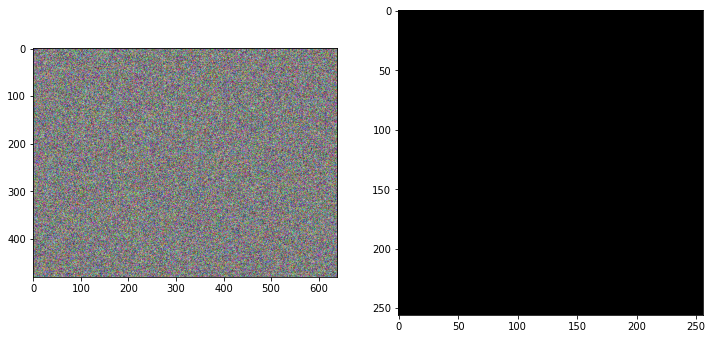

In [55]:
image = np.random.random((480, 640, 3))
input_image, _ = preprocess(image, 256, 256)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(input_image[0])
plt.show()
x_data = np.array([input_image[0], ] * 1000)

annotation y_true

In [56]:
ground_truth_labels = np.array([[1]])
ground_truth_box = np.array([129.64256-60.13495/2, 153.4913-60.13495/2, 129.64256+60.13495/2, 153.4913+60.13495/2, 136.83605957, 177.14094543, 118.33981323, 127.28881073, 130.82832336, 126.52574158, 142.27386475, 131.28793335, 152.84526062, 137.67770386, 119.28163147, 173.47927856, 105.67642212, 152.75184631]).reshape(1, -1)
annotation = [ground_truth_labels, ground_truth_box/256]

In [57]:
num_anchors = 2944
num_coordinates = 18
num_key_points = 7
num_classes = 1
positive_threshold = 0.5
negative_threshold = 0.5

In [58]:
annotation[1].shape

(1, 18)

In [59]:
y_data = np.zeros((1000, num_anchors, num_classes+num_coordinates))
for i in range(1000):
    conf, loc = match(annotation, anchors_normalized, match_threshold=0.5)
    y_data[i] = np.concatenate([conf, loc * 256], axis=-1)

In [60]:
y_data.shape

(1000, 2944, 19)

In [61]:
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss()
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [62]:
history = model.fit(x=x_data, y=y_data, steps_per_epoch=10, epochs=10, batch_size=4)

Train on 1000 samples
Epoch 1/10
   4/1000 [..............................] - ETA: 23:21

KeyboardInterrupt: 

## Test Model

In [240]:
pred = model.predict(input_image)

In [241]:
def sigmoid(values):
    return 1/(1+np.exp(-values))

In [242]:
output_clf = pred[:,:,0][0]
scores = sigmoid(output_clf)

In [243]:
output_reg = pred[:,:,1:][0]

In [244]:
output_reg = output_reg[scores>0.9999999]
output_clf = output_clf[scores>0.9999999]
candidate_anchors = anchors_normalized[scores>0.9999999]

In [245]:
moved_output_reg = output_reg.copy()
moved_output_reg[:, :2] = moved_output_reg[:, :2] + candidate_anchors[:, :2] * 256

In [246]:
def non_max_suppression_fast(boxes, probabilities=None, overlap_threshold=0.3):
    """
    Algorithm to filter bounding box proposals by removing the ones with a too low confidence score
    and with too much overlap.
    Source: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    :param boxes: List of proposed bounding boxes
    :param overlap_threshold: the maximum overlap that is allowed
    :return: filtered boxes
    """
    # if there are no boxes, return an empty list
    if boxes.shape[1] == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0] - (boxes[:, 2] / [2])  # center x - width/2
    y1 = boxes[:, 1] - (boxes[:, 3] / [2])  # center y - height/2
    x2 = boxes[:, 0] + (boxes[:, 2] / [2])  # center x + width/2
    y2 = boxes[:, 1] + (boxes[:, 3] / [2])  # center y + height/2

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = boxes[:, 2] * boxes[:, 3]  # width * height
    idxs = y2


    # if probabilities are provided, sort on them instead
    if probabilities is not None:
        idxs = probabilities

    # sort the indexes
    idxs = np.argsort(idxs)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlap_threshold)[0])))
    # return only the bounding boxes that were picked
    return pick

In [247]:
box_ids = non_max_suppression_fast(moved_output_reg[:, :4], output_clf)

In [248]:
center_wo_offst = candidate_anchors[box_ids,:2] * 256
bboxes = moved_output_reg[box_ids, :4].astype('int')
keypoints_set = output_reg[box_ids,4:].reshape(-1, 7, 2)
for i in range(len(keypoints_set)):
    keypoints_set[i] = keypoints_set[i] + center_wo_offst[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


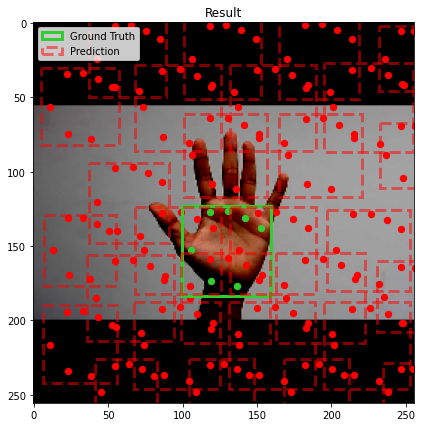

In [256]:
color = ['limegreen', 'r']
width = [3, 3]
style = ['-', '--']
alpha = [1, 0.5]


plt.figure(figsize=(7, 7))
plt.title("Result")
result_image = input_image.copy()[0]

x1, y1, x2, y2 = annotation[1][:,:4][0]*256
rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[0], ec=color[0], ls=style[0], alpha=alpha[0], facecolor="none", label='Ground Truth')
plt.gca().add_patch(rect)
# plt.scatter((x2+x1)/2, (y2+y1)/2, color=color[0], s=87)
for key_point in annotation[1][0,4:].reshape(-1,2)*256:
    plt.scatter(key_point[0], key_point[1], color=color[0], s=40)
    
for i in range(len(bboxes)):
    cx, cy, w, h = bboxes[i][:4]
    x1, y1, x2, y2 = (cx-w//2, cy-h//2, cx+w//2, cy+h//2)
    if i == 0:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[1], ec=color[1], ls=style[1], alpha=alpha[1], facecolor="none", label='Prediction')
    else:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[1], ec=color[1], ls=style[1], alpha=alpha[1], facecolor="none")
    plt.gca().add_patch(rect)
#     plt.scatter((x2+x1)/2, (y2+y1)/2, color=color[1], s=87)
    for key_point in keypoints_set[i]:
        plt.scatter(key_point[0], key_point[1], color=color[1], s=40)

plt.legend()
plt.imshow(result_image)
plt.show()

In [257]:
pred_id = np.argmax(pred[0,:,0])
pred_loc = pred[0,:,1:][pred_id]
pred_loc[:2] = anchors_normalized[pred_id,:2]*256 + pred_loc[:2]
pred_loc[:4] = center_to_corner(np.array([pred_loc[:4]]))
pred_loc[4:] = (pred_loc[4:].reshape(-1, 2) + anchors_normalized[pred_id,:2]*256).reshape(-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


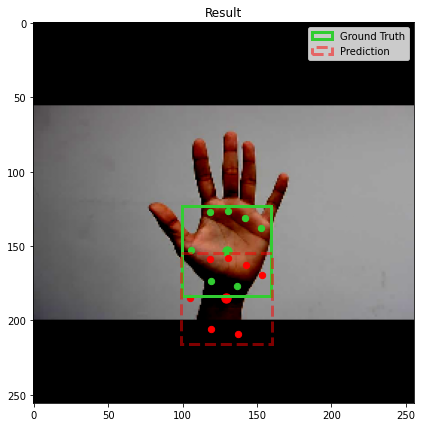

In [258]:
color = ['limegreen', 'r']
width = [3, 3]
style = ['-', '--']
alpha = [1, 0.5]


plt.figure(figsize=(7, 7))
plt.title("Result")
result_image = input_image.copy()[0]

x1, y1, x2, y2 = annotation[1][:,:4][0]*256
rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[0], ec=color[0], ls=style[0], alpha=alpha[0], facecolor="none", label='Ground Truth')
plt.gca().add_patch(rect)
plt.scatter((x2+x1)/2, (y2+y1)/2, color=color[0], s=87)
for key_point in annotation[1][0,4:].reshape(-1,2)*256:
    plt.scatter(key_point[0], key_point[1], color=color[0], s=40)
    

x1, y1, x2, y2 = pred_loc[:4]
rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, lw=width[1], ec=color[1], ls=style[1], alpha=alpha[1], facecolor="none", label='Prediction')
plt.gca().add_patch(rect)
plt.scatter((x2+x1)/2, (y2+y1)/2, color=color[1], s=87)
for key_point in pred_loc[4:].reshape(-1, 2):
    plt.scatter(key_point[0], key_point[1], color=color[1], s=40)

plt.legend()
plt.imshow(result_image)
plt.show()